In [1]:
import glob
import stingray as st
import numpy as np
from stingray import Lightcurve, AveragedPowerspectrum
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,12]

lc_fnames = sorted(glob.glob('pps/P*PNX*SRCTSR*.FTZ'))
evt_names = sorted(glob.glob('0*evts.fits'))

lcs = []
backlcs = []
slcs = []
hlcs = []
for file in lc_fnames:
    hdul = fits.open(file)
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    backrate = hdul[1].data.field('BACKV')
    err = hdul[1].data.field('ERROR')
    soft = hdul[1].data.field('RATE1') + hdul[1].data.field('RATE2') + hdul[1].data.field('RATE3')
    hard = hdul[1].data.field('RATE4') + hdul[1].data.field('RATE5')
    ers = hdul[1].data.field('RATE1_ERR') + hdul[1].data.field('RATE2_ERR') + hdul[1].data.field('RATE3_ERR')
    erh = hdul[1].data.field('RATE4_ERR') + hdul[1].data.field('RATE5_ERR')
    gtis = []
    max_gti = 0
    for i in hdul[2].data:
        gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    lcs.append(Lightcurve(time, rate, err, gti=gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, err, gti=gtis, input_counts=False))
    slcs.append(Lightcurve(time, soft, ers, gti=gtis, input_counts=False))
    hlcs.append(Lightcurve(time, hard, erh, gti=gtis, input_counts=False))
    
print(max_gti)

8654.879999995232


/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")


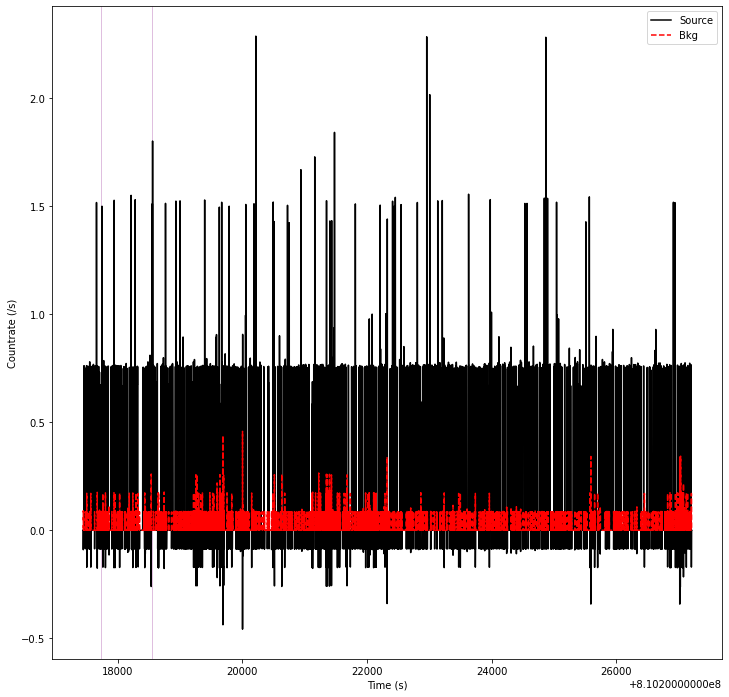

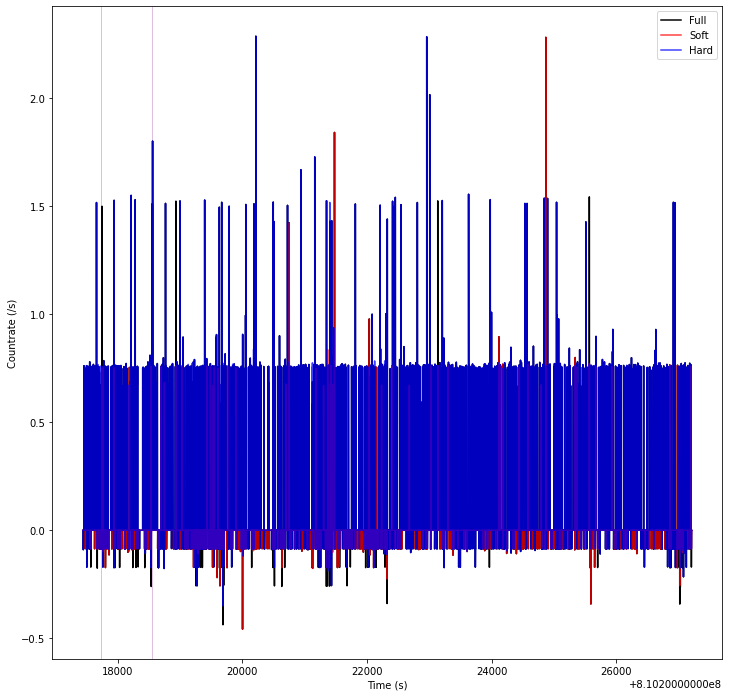

In [2]:
for i in range(len(lcs)):
    plt.xlabel('Time (s)')
    plt.ylabel('Countrate (/s)')
    plt.plot(lcs[i].time, lcs[i].countrate, color='k', ds='steps-mid', label='Source')
    plt.plot(backlcs[i].time, backlcs[i].countrate, color='r', ls='--', ds='steps-mid', label='Bkg')
    plt.legend(loc='upper right')
    for j in range(len(lcs[i].gti)-1):
        plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
    plt.show()
    plt.xlabel('Time (s)')
    plt.ylabel('Countrate (/s)')
    plt.plot(lcs[i].time, lcs[i].countrate, color='k', ds='steps-mid', label='Full')
    plt.plot(slcs[i].time, slcs[i].countrate, color='r', ds='steps-mid', alpha=0.75, label='Soft')
    plt.plot(hlcs[i].time, hlcs[i].countrate, color='b', ds='steps-mid', alpha=0.75, label='Hard')
    plt.legend(loc='upper right')
    for j in range(len(lcs[i].gti)-1):
        plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
    plt.show()

/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt
1it [00:00, 187.40it/s]
1it [00:00, 866.95it/s]
1it [00:00, 1075.74it/s]


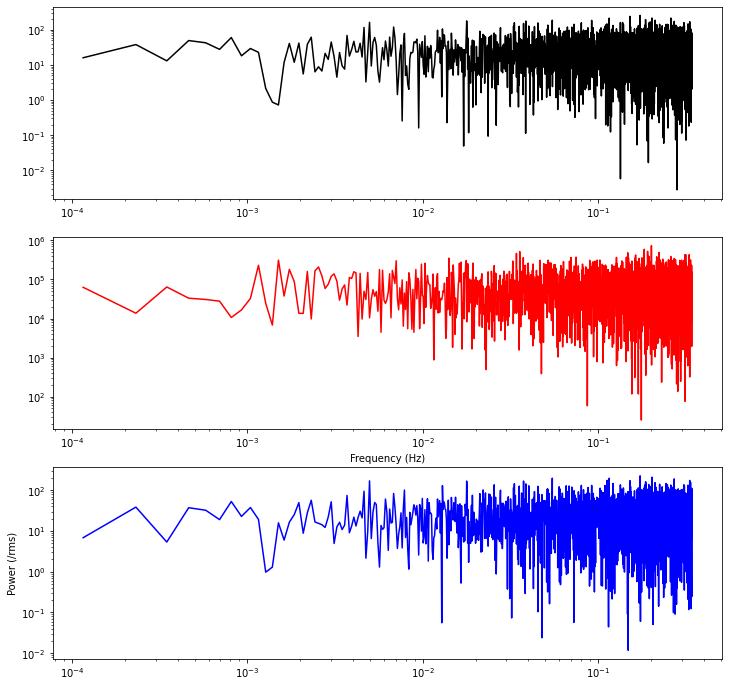

In [3]:
apsd = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
apsds = AveragedPowerspectrum(slcs[0],segment_size=max_gti)
apsdh = AveragedPowerspectrum(hlcs[0],segment_size=max_gti)
fig, axs = plt.subplots(3,1)
axs[0].loglog(apsd.freq,apsd.power,color='k')
axs[1].loglog(apsds.freq,apsds.power,color='r')
axs[2].loglog(apsdh.freq,apsdh.power,color='b')
axs[1].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power (/rms)')
plt.show()

/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
1it [00:00, 940.22it/s]
1it [00:00, 2368.33it/s]
1it [00:00, 2279.51it/s]


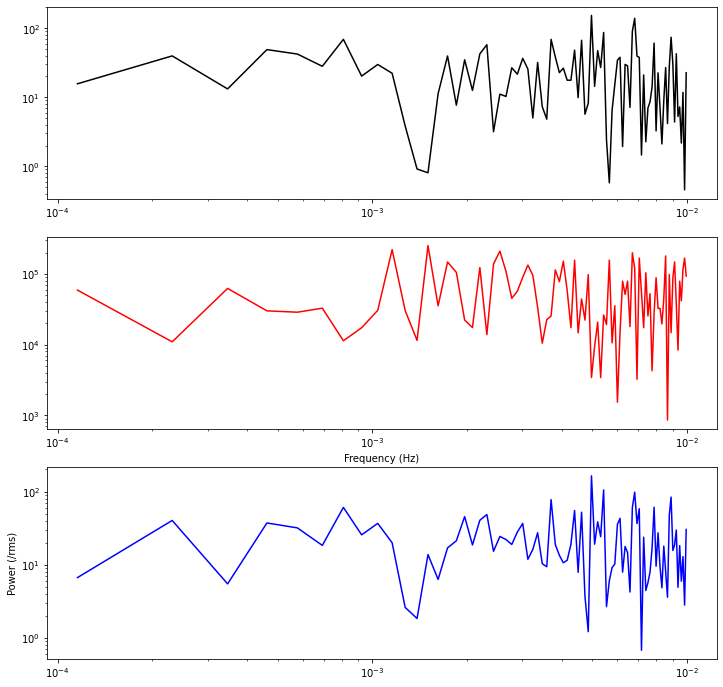

In [4]:
apsd = AveragedPowerspectrum(lcs[0].rebin(50),segment_size=max_gti)
apsds = AveragedPowerspectrum(slcs[0].rebin(50),segment_size=max_gti)
apsdh = AveragedPowerspectrum(hlcs[0].rebin(50),segment_size=max_gti)
fig, axs = plt.subplots(3,1)
axs[0].loglog(apsd.freq,apsd.power,color='k')
axs[1].loglog(apsds.freq,apsds.power,color='r')
axs[2].loglog(apsdh.freq,apsdh.power,color='b')
axs[1].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power (/rms)')
plt.show()

In [5]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
source_events = st.EventList.read(evt_names[0],fmt_='hea',skip_checks=True)

In [6]:
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

obs_length = max(source_events.time) - min(source_events.time)
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(2*df_min, 5, df)

freq, efstat = epoch_folding_search(source_events.time, frequencies, nbin=32)
freq, zstat = z_n_search(source_events.time, frequencies, nbin=32, nharm=1)

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

In [7]:
print(len(cand_freqs_ef))
print(len(cand_freqs_z))

0
0


In [8]:
for i in range(len(cand_freqs_ef)):
    print(cand_freqs_ef[i],cand_stat_ef[i])

In [9]:
for i in range(len(cand_freqs_z)):
    print(cand_freqs_z[i],cand_stat_z[i])

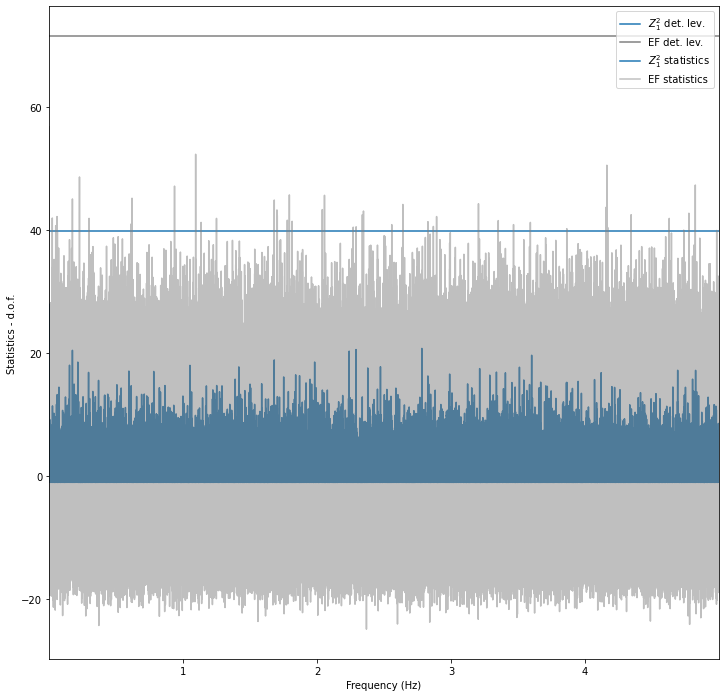

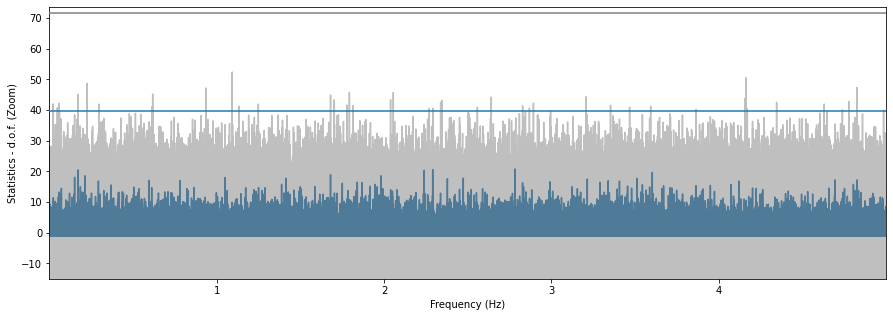

In [10]:
nharm=1
nbin=32
plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

In [11]:
f0 = 
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(source_events.time, f0)
_ = plot_profile(ph,profile)

SyntaxError: invalid syntax (<ipython-input-11-fa7b6cffbb81>, line 1)

In [ ]:
f0 = 
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(source_events.time, f0)
_ = plot_profile(ph,profile)

In [12]:
hard_source_events = source_events.filter_energy_range([2000,12000],use_pi=True)

obs_length = max(hard_source_events.time) - min(hard_source_events.time)
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(2*df_min, 5, df)

freq, efstat = epoch_folding_search(hard_source_events.time, frequencies, nbin=32)
freq, zstat = z_n_search(hard_source_events.time, frequencies, nbin=32, nharm=1)

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

In [13]:
print(len(cand_freqs_ef))
print(len(cand_freqs_z))

0
0
